In [4]:
fname = 'ASTR19_S22_group_project_data.txt'
#open the file with read mode
f = open(fname,'r')

#print the name of the file
print(f.name)
#read the data as a string
test_data = f.read()
#print the info from the file
print(test_data)

ASTR19_S22_group_project_data.txt
#Column A: Day of the year
#Column B: Time in hours:minutes
#Column B: Tide Height in feet
 1  8:07  6.57
 1 15:37 -0.39
 2  8:55  5.38
 2 16:25 -1.74
 3  9:45  5.26
 3 17:14 -1.36
 4 10:35  4.13
 4 18:00 -1.15
 5 11:28  3.48
 5 18:46 -1.61
 6 12:22  2.62
 6 19:31  0.05
 7 13:24  1.83
 7 20:16  1.01
 8  3:22  3.57
 8 21:01  0.73
 9  4:07  4.54
 9 21:46  2.17
10  4:50  3.76
10 11:58  2.88
11  5:31  3.90
11 12:56  1.92
12  6:08  4.73
12 13:45  1.74
13  6:47  5.66
13 14:25  0.79
14  7:22  5.33
14 15:00 -0.04
15  7:59  5.23
15 15:34 -1.12
16  8:34  6.67
16 16:08 -0.61
17  9:10  4.74
17 16:41 -0.93
18  9:45  4.69
18 17:12 -1.29
19 10:21  4.20
19 17:45  0.22
20 10:57  3.68
20 18:15  0.26
21 11:38  2.47
21 18:48  0.36
22 12:25  2.59
22 19:20  0.99
23  2:22  4.10
23 19:52  1.87
24  2:58  3.17
24 20:30  1.60
25  3:37  3.71
25 10:44  3.10
26  4:23  4.04
26 11:55  2.49
27  5:15  4.07
27 12:57  2.18
28  6:09  5.93
28 13:50  0.70
29  7:05  6.89
29 14:39  0.21
30  7

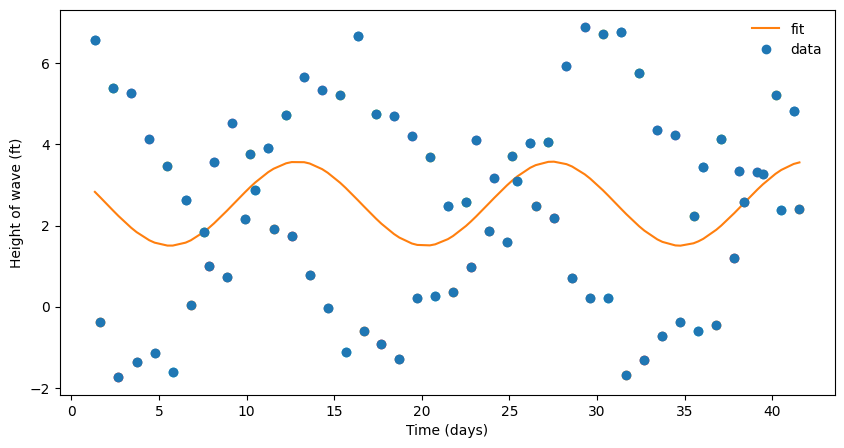

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import tensorflow as tf
    
#define the filename
fname = 'ASTR19_S22_group_project_data.txt'

#open the file with numpy loadtxt
test_data = np.loadtxt(fname, dtype={'names': ('day', 'time', 'height'),'formats': ('i4', 'S5', 'f4')})

#print the info from the file
#print(test_data)

#plt.style.use("Downloads/astr19_matplotlib_defaults.txt")
fig = plt.figure(figsize=(10,5))
ax = plt.subplot
plt.xlabel('Time (days)')
plt.ylabel('Height of wave (ft)')


result_x = []
result_y = []
for item in test_data:
    day = item [0]
    time = item [1].decode()
    height = item [2]
    Day = (day)
    TimeParts = time.split(":")
    daysfromhour = int(TimeParts[0])/24
    daysfromminutes = int(TimeParts[1])/60/24
    timeindays = day + daysfromhour + daysfromminutes
    #print ("("+ str(totalMinutes) +"," + str(height)+")")
    x = timeindays
    y = height
    result_x.append(x)
    result_y.append(y)
    plt.scatter(x,y)

result_x = np.asarray(result_x)
result_y = np.asarray(result_y)
#print(result_x)

#curve fitting???

#define the function to fit
def f_line(x, a, b, c, d):
    return a * np.sin(b*x + c) + d
    #function should be something like sinx+(sinx)(sinx) with transformations
    #(a * np.sin(b*x + c) + d) + (e * np.sin(f*x + g) + h) * (i * np.sin(j*x + k) + l) maybe

#perform the fit
#p0 uses random numbers
params, params_cov = scipy.optimize.curve_fit(f_line, result_x, result_y, p0=[3, 0.5, 1, 2])

a_fit = params[0]
b_fit = params[1]
c_fit = params[2]
d_fit = params[3]

#print(f'params {a_fit}, {b_fit}, {c_fit}, {d_fit}')

y_fit = a_fit * np.sin(b_fit*result_x + c_fit) + d_fit
#print(result_x)
#print(y_fit)

#plot the fit on the same graph
plt.errorbar(result_x, result_y, fmt='o', label='data')
plt.plot(result_x, y_fit, label='fit')
plt.legend(loc=0, frameon=False)
plt.show()     #delete later

#plt.savefig('project-figure.pdf', bbox_inches='tight', dpi=600)

In [32]:
result_x = []
result_y = []
def main(x,y):
    for item in test_data:
        day = item [0]
        time = item [1].decode()
        height = item [2]
        Day = (day)
        TimeParts = time.split(":")
        daysfromhour = int(TimeParts[0])/24
        daysfromminutes = int(TimeParts[1])/60/24
        timeindays = day + daysfromhour + daysfromminutes
        #print ("("+ str(totalMinutes) +"," + str(height)+")")
        x = timeindays
        y = height
        result_x.append(x)
        result_y.append(y)
        result_x = np.asarray(result_x)
        result_y = np.asarray(result_y)
        plt.scatter(x,y)
print(x)
print(y)
print(result_x)
print(result_y)



41.55138888888889
2.41
[]
[]


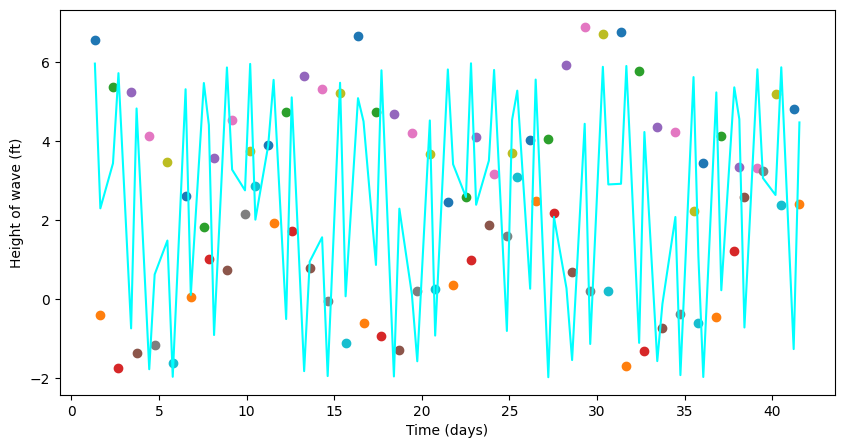

In [43]:
#define the filename
fig = plt.figure(figsize=(10,5))
ax = plt.subplot
plt.xlabel('Time (days)')
plt.ylabel('Height of wave (ft)')


result_x = []
result_y = []
for item in test_data:
    day = item [0]
    time = item [1].decode()
    height = item [2]
    Day = (day)
    TimeParts = time.split(":")
    daysfromhour = int(TimeParts[0])/24
    daysfromminutes = int(TimeParts[1])/60/24
    timeindays = day + daysfromhour + daysfromminutes
    x = timeindays
    y = height
    result_x.append(x)
    result_y.append(y)
    plt.scatter(x,y)

result_x = np.asarray(result_x)
result_y = np.asarray(result_y)




#amplitude
A_init = 4.0
A_fit = tf.Variable(A_init, name='amplitude')
#frequency
f_init = 5.0
f_fit = tf.Variable(f_init, name='frequency')
#phase
p_init = 20.0
p_fit = tf.Variable(p_init, name='phase')
#vertical shift
d_init = 2.0
d_fit = tf.Variable(d_init, name='vertical shift')

#sinusoidal curve
def sinusoid(x, A, f, p, d):
    return A*np.sin(f*x+p)+d

#define the sinusoidal model
@tf.function
def sinusoidal_model(result_x):
    return A_fit * tf.math.sin(f_fit*x + p_fit)


#define the loss function
@tf.function
def mse(y_true, y_pred):
    #mse between true and predicted values
    return tf.losses.mean_squared_error(y_true, y_pred)


#Adam optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)


#start training
epochs = 5000     #number of epochs to run
display_step = 1000    #number of epochs between printing info to screen
for epoch in range(epochs):
    #monitor training/display steps
    if((epoch%display_step)==0):
        pred = sinusoidal_model(result_x)
        loss = mse(pred, result_y)
        #to print this info, we need to convert to numpy arrays
        #print(f'Epoch {epoch} | Loss {loss.numpy()}, A: {A_fit.numpy()} f: {f_fit.numpy()} p: {p_fit.numpy()}')
    #in TF2, gradients are handled using the GradientTape class.
    #begin GradientTape and optimize
    with tf.GradientTape() as g:
        pred = sinusoidal_model(result_x)
        loss = mse(result_y, pred)
    #compute dm, db, the gradients with respect to m_fit and b_fit
    gradients = g.gradient(loss, [A_fit, f_fit, p_fit])
    #update m_fit adn b_fit with the gradients x learning
    optimizer.apply_gradients(zip(gradients, [A_fit, f_fit, p_fit]))
#print the last answer
#print(f'Epoch {epoch} | Loss {loss.numpy()}, A: {A_fit.numpy()} f: {f_fit.numpy()} p: {p_fit.numpy()}')
#print("Done!")


x_model = np.sort(result_x)
y_model = sinusoid(x_model, A_fit, f_fit, p_fit, d_fit)

plt.plot(x_model, y_model, color='cyan', label='BFM')


#f, ax = plt.subplots(1, 1, figsize=(10,5))
#plt.errorbar(result_x, result_y, fmt='o', label='Data')
#ax.plot(x_model, y_model, color='magenta', label='Best-fit model')
#plt.set_xlim([-0.1,10.1])
#plt.set_ylim([-2.,2])
#ax.text(0.5, 1.2, r'$\sigma = 1$', color='0', fontsize=32)
#ax.set_xlabel('x', fontsize=20)
#ax.set_ylabel('y', fontsize=20)
#plt.legend(frameon=False, fontsize=20, handletextpad=0)